In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd

import sys  
# to include the src files
sys.path.insert(0, '../src')

In [3]:
from feature_extraction import gabor_feature_extractor

In [4]:
%matplotlib inline

In [5]:
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.filters import sobel, roberts, scharr, prewitt

In [6]:
from scipy import ndimage as nd

## Setting the folder path 

In [7]:
BASE_DIR = "../"
data_dir = BASE_DIR  + "data/raw/"
os.listdir(data_dir)

['Train_images',
 'Test_masks',
 'README.org~',
 'Train_masks',
 'README.org',
 'Test_images']

In [8]:
images_path = data_dir + "Train_images/" 
masks_path  = data_dir + "Train_masks/" 

In [9]:
images = sorted(os.listdir(images_path))
print(len(images))
images

5


['Sandstone_Versa0000.tif',
 'Sandstone_Versa0050.tif',
 'Sandstone_Versa0100.tif',
 'Sandstone_Versa0150.tif',
 'Sandstone_Versa0200.tif']

In [10]:
masks = sorted(os.listdir(masks_path))
masks

['Sandstone_Versa0000.tif',
 'Sandstone_Versa0050.tif',
 'Sandstone_Versa0100.tif',
 'Sandstone_Versa0150.tif',
 'Sandstone_Versa0200.tif']

## Let's view the image and it's mask

(1024, 996)
(1024, 996)


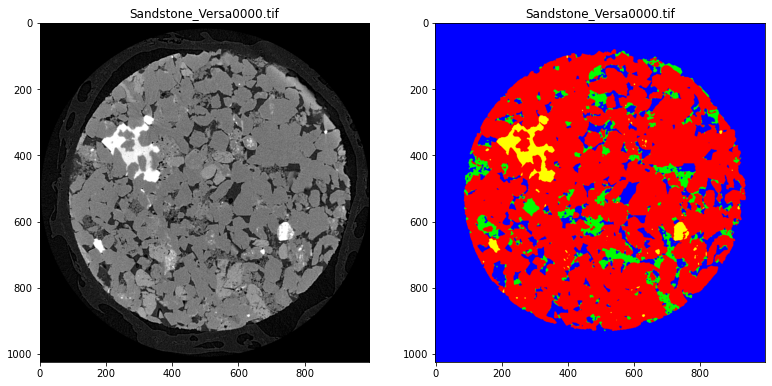

In [11]:
for image, mask in zip(images, masks):
    fig, ax = plt.subplots(1,2,figsize=(13,13))
    
    read_image = cv2.imread(images_path + image, 0) 
    print(read_image.shape)
    
    read_mask = cv2.imread(masks_path + mask) 
    read_mask_rgb = cv2.cvtColor(read_mask, cv2.COLOR_BGR2RGB)
    read_mask_gray = cv2.cvtColor(read_mask, cv2.COLOR_BGR2GRAY)
    print(read_mask_gray.shape)
    
    ax[0].imshow(read_image, cmap="gray")
    ax[0].set_title(image)
    ax[1].imshow(read_mask_rgb)
    ax[1].set_title( mask)
    
    break

## Feature Extraction

### Pixel Values Extraction

#### For our image

In [12]:
pixel_values_image = read_image.reshape(-1)
pixel_values_image.shape

(1019904,)

##### lets see the pixel value histogram

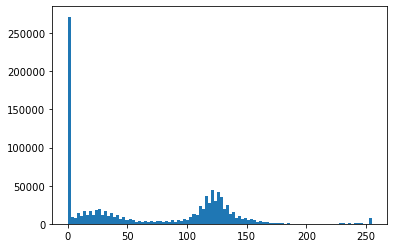

In [13]:
plt.hist(pixel_values_image, bins=100, range=(0,255))
plt.show()

#### For our label/mask

In [14]:
## we are taking gray mask because we want single label 
pixel_value_mask = read_mask_gray.reshape(-1)
pixel_value_mask.shape

(1019904,)

In [15]:
np.unique(pixel_value_mask) ## these are the four gray intensities

array([ 29,  76, 150, 226], dtype=uint8)

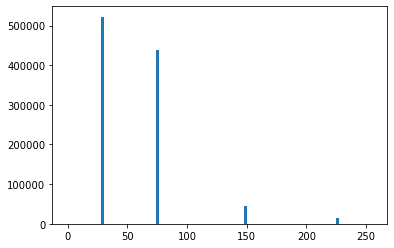

In [16]:
plt.hist(pixel_value_mask, bins=100, range=(0,255))
plt.show()

### Gabor Filters

In [17]:
"""
# sigma = sigma
# lam  = lambda
# theta = theta 
# gamma = gamma 

# cv2.getGaborKernel(ksize, sigma, theta, lambda, gamma, psi, ktype)

ksize is the size of the Gabor kernel. 
If ksize = (a, b), we then have a Gabor kernel of size a x b pixels. 
As with many other convolution kernels, 
ksize is preferably odd and the kernel is a square (just for the sake of uniformity).

sigma is the standard deviation of the Gaussian function used in the Gabor filter.

theta is the orientation of the normal to the parallel stripes of the Gabor function.

lambda is the wavelength of the sinusoidal factor in the above equation.

gamma is the spatial aspect ratio.

psi is the phase offset.

ktype indicates the type and range of values that each pixel in the Gabor kernel can hold. 

Reading links
- https://cvtuts.wordpress.com/2014/04/27/gabor-filters-a-practical-overview/
- https://medium.com/@anuj_shah/through-the-eyes-of-gabor-filter-17d1fdb3ac97
"""
ksize = 9
phi = 0

count = 0
GABOR_FILTER_BANK = {}
for i in range(3): # 0, 45, and 90 degree
    theta = i/4.0 * np.pi
    for sigma in (1, 3):
        for lam in np.arange(0.1, np.pi, np.pi/4.0): # 0 to 135 degree with 45degree step
            for gamma in (0.05, 0.5):
                gabor_name = "gabor_" + str(count) 
#                 if lam==0:
#                     print(f"{gabor_name} -> {theta}, {sigma}, {lam}, {gamma}")
                kernel = cv2.getGaborKernel((ksize, ksize),
                                            sigma,
                                            theta,
                                            lam,
                                            gamma,
                                            phi,
                                            ktype=cv2.CV_32F)
        
                GABOR_FILTER_BANK[gabor_name] = kernel
                count +=1
print(count)  # 48
print("done")

48
done


In [18]:
GABOR_FILTER_BANK.keys()

dict_keys(['gabor_0', 'gabor_1', 'gabor_2', 'gabor_3', 'gabor_4', 'gabor_5', 'gabor_6', 'gabor_7', 'gabor_8', 'gabor_9', 'gabor_10', 'gabor_11', 'gabor_12', 'gabor_13', 'gabor_14', 'gabor_15', 'gabor_16', 'gabor_17', 'gabor_18', 'gabor_19', 'gabor_20', 'gabor_21', 'gabor_22', 'gabor_23', 'gabor_24', 'gabor_25', 'gabor_26', 'gabor_27', 'gabor_28', 'gabor_29', 'gabor_30', 'gabor_31', 'gabor_32', 'gabor_33', 'gabor_34', 'gabor_35', 'gabor_36', 'gabor_37', 'gabor_38', 'gabor_39', 'gabor_40', 'gabor_41', 'gabor_42', 'gabor_43', 'gabor_44', 'gabor_45', 'gabor_46', 'gabor_47'])

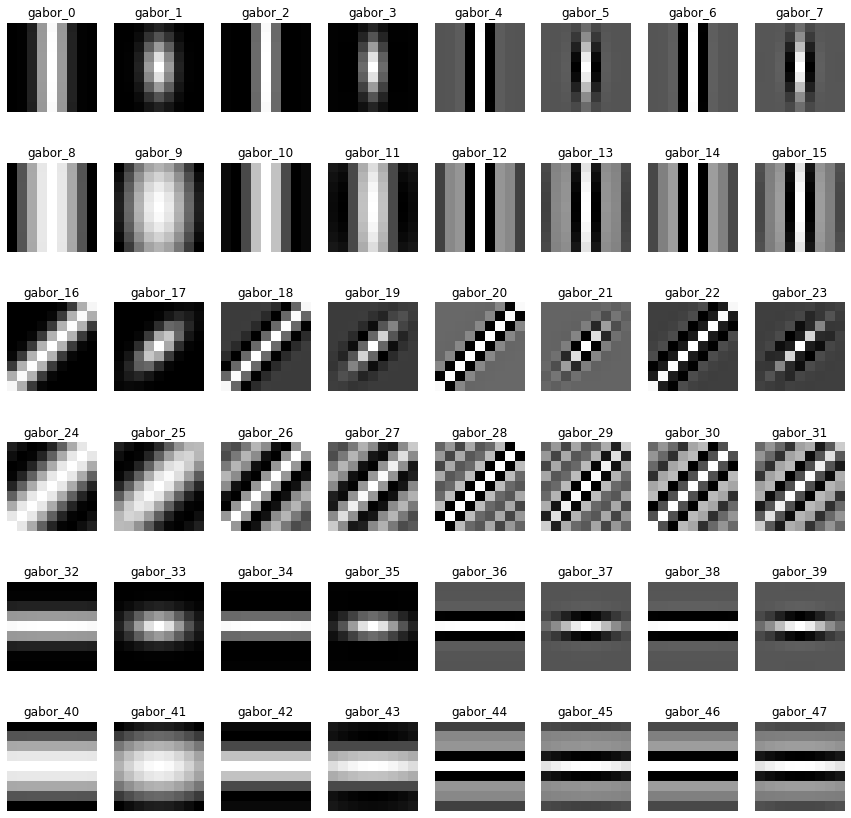

In [19]:
fig = plt.figure(figsize=(15,15))

for i,filters in enumerate(GABOR_FILTER_BANK):
#     print(filters.shape)
    ax = plt.subplot(6, 8, i+1)
    plt.imshow(GABOR_FILTER_BANK[filters], cmap="gray")
    plt.axis("off")
    ax.set_title(f"{filters}")

# fig.savefig("48_Gabor_filters.png")

In [20]:
help(gabor_feature_extractor)

Help on function gabor_feature_extractor in module feature_extraction:

gabor_feature_extractor(image)
    Applies 48 gabor filters and
    returns the dictionary containing
    the features obatined after applying those images



In [21]:
gabor_features  = gabor_feature_extractor(read_image)
gabor_features.keys()

dict_keys(['gabor_0', 'gabor_1', 'gabor_2', 'gabor_3', 'gabor_4', 'gabor_5', 'gabor_6', 'gabor_7', 'gabor_8', 'gabor_9', 'gabor_10', 'gabor_11', 'gabor_12', 'gabor_13', 'gabor_14', 'gabor_15', 'gabor_16', 'gabor_17', 'gabor_18', 'gabor_19', 'gabor_20', 'gabor_21', 'gabor_22', 'gabor_23', 'gabor_24', 'gabor_25', 'gabor_26', 'gabor_27', 'gabor_28', 'gabor_29', 'gabor_30', 'gabor_31', 'gabor_32', 'gabor_33', 'gabor_34', 'gabor_35', 'gabor_36', 'gabor_37', 'gabor_38', 'gabor_39', 'gabor_40', 'gabor_41', 'gabor_42', 'gabor_43', 'gabor_44', 'gabor_45', 'gabor_46', 'gabor_47'])

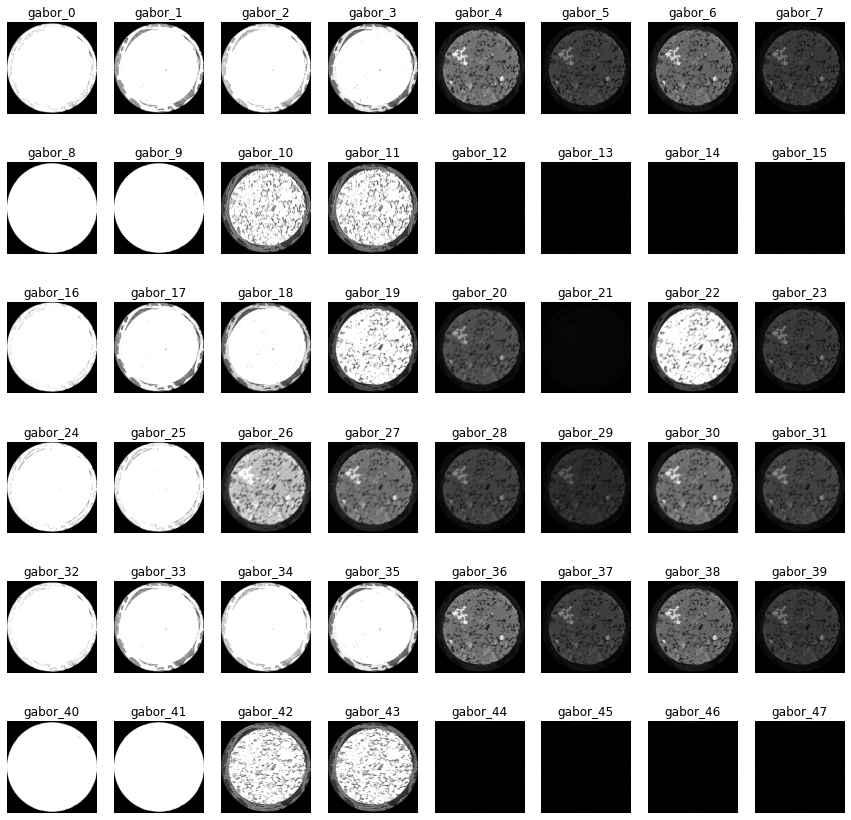

In [22]:
fig = plt.figure(figsize=(15,15))

for i,feature in enumerate(gabor_features):
#     print(filters.shape)
    ax = plt.subplot(6, 8, i+1)
    plt.imshow(gabor_features[feature], cmap="gray")
    plt.axis("off")
    ax.set_title(f"{feature}")

# fig.savefig("48_features_from_gabor.png")

### Other filters
- 9 other filters
- show the features extracted from these filters

In [33]:
filter_label = ['Original','Entropy', 'Gaussian3','Gaussian7', 'Sobel',
               'Canny', 'Robert', 'Scharr', 'Prewitt', 'Median', 'Variance']

In [24]:
len(filter_label)

11

In [37]:
# fig = plt.figure(figsize=(15,15))
for index,image in enumerate(images):
    image = cv2.imread(os.path.join(images_path, image))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    entropy_img = entropy(image, disk(1))
    gaussian3_img = nd.gaussian_filter(image, sigma=3)
    gaussian7_img = nd.gaussian_filter(image, sigma = 7)
    sobel_img = sobel(image)
    canny_edge_img = cv2.Canny(image,100,200)
    robert_edge_img  = roberts(image)
    scharr_edge = scharr(image)
    prewitt_edge = prewitt(image)
    median_img = nd.median_filter(image, size = 3)
    variance_img = nd.generic_filter(image, np.var, size = 3)
    
    FEATURES = [image, entropy_img, gaussian3_img, gaussian7_img, sobel_img,
              canny_edge_img, robert_edge_img, scharr_edge, 
              prewitt_edge, median_img, variance_img]

#     ax = plt.subplot(3,4, index+1)
#     fig, ax = plt.subplots(3,4,figsize=(13,13))
#     count = 0
#     for i in range(3):
#         for j in range(4):
#             ax[i][j].imshow(FILTERS[count], cmap='gray')
#             ax[i][j].set_title(filter_label[count])
#             count+=1
    

    image1d = image.reshape(-1)
    entropy1d = entropy_img.reshape(-1)
    gaussian3_1d = gaussian3_img.reshape(-1)
    gaussian7_1d = gaussian7_img.reshape(-1)
    sobel1d = sobel_img.reshape(-1)
    canny_edge1d = canny_edge_img.reshape(-1)
    robert_edge1d = robert_edge_img.reshape(-1)
    scharr_edge1d = scharr_edge.reshape(-1)
    prewitt_edge1d = prewitt_edge.reshape(-1)
    median1d = median_img.reshape(-1)
    variance1d = variance_img.reshape(-1)
    FEATURES_RESHAPED = [image1d, entropy1d, gaussian3_1d, gaussian7_1d,
                        sobel1d, canny_edge1d, robert_edge1d, scharr_edge1d,
                        prewitt_edge1d, median1d, variance1d]
            
#     cv2.imshow('Original Image', image)
#     cv2.imshow('Entropy Image', entropy_img)
#     cv2.imshow('Gaussian3 Image', gaussian3_img)
#     cv2.imshow('Gaussian7 Image', gaussian7_img)
#     cv2.imshow('Sobel Filtered Image', sobel_img)
#     cv2.imshow('Canny Edge', canny_edge_img)
#     cv2.imshow('Scharr Edge', scharr_edge)
#     cv2.imshow('Guassian7', gaussian7_img)
#     cv2.imshow('Robert', robert_edge_img)
#     cv2.imshow('Prewitt', prewitt_edge)
#     cv2.imshow('Median', median_img)
#     cv2.imshow('Variance', variance_ig)

#     cv2.waitKey(0)
    break
    
# cv2.destroyAllWindows()

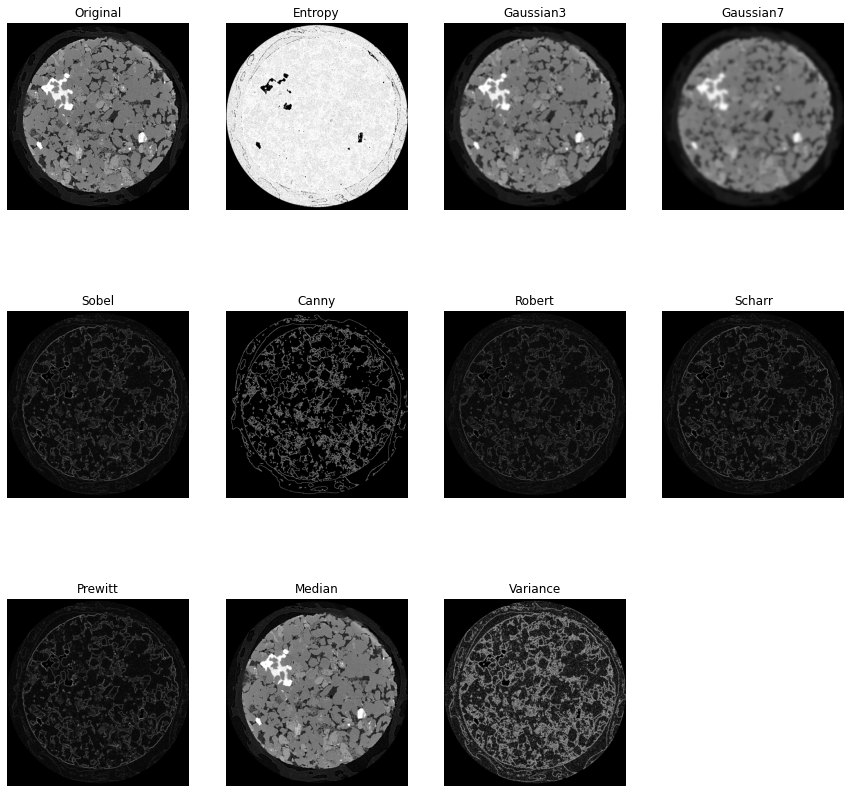

In [47]:
fig = plt.figure(figsize=(15,15))

for i,feature in enumerate(FEATURES):
#     print(filters.shape)
    ax = plt.subplot(3, 4, i+1)
#     filter_applied = cv2.filter2D(read_image, cv2.CV_8UC3, GABOR_FILTER_BANK[filters])
    plt.imshow(feature, cmap="gray")
    plt.axis("off")
    ax.set_title(f"{filter_label[i]}")

fig.savefig("10_other_features.png")

## Creating the Dataframe object
- save in ./data/processed folder
- now create the dataframe merging all the filters and the labels

In [17]:
final_dataframe = pd.DataFrame()

In [18]:
final_dataframe["Pixel_Value"] = read_image.reshape(-1)

#### adding gabor features

In [19]:
for i,filters in enumerate(GABOR_FILTER_BANK):
    filter_applied = cv2.filter2D(read_image, cv2.CV_8UC3, GABOR_FILTER_BANK[filters])
    final_dataframe[filters] = filter_applied.reshape(-1)

#### add other features 

In [43]:
for index in range(1, len(filter_label)):
    final_dataframe[filter_label[index]] = FEATURES_RESHAPED[index]

#### adding the final mask label

In [20]:
final_dataframe["Mask_label"] = read_mask_gray.reshape(-1)

In [45]:
final_dataframe.head()

,Pixel_Value,gabor_0,gabor_1,gabor_2,gabor_3,gabor_4,gabor_5,gabor_6,gabor_7,gabor_8,...,Entropy,Gaussian3,Gaussian7,Sobel,Canny,Robert,Scharr,Prewitt,Median,Variance
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0,0,0.0,0,0.0,0.0,0.0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0,0,0.0,0,0.0,0.0,0.0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0,0,0.0,0,0.0,0.0,0.0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0,0,0.0,0,0.0,0.0,0.0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0,0,0.0,0,0.0,0.0,0.0,0,0


In [46]:
final_dataframe.shape # with 9 extra feature it should be 59 

(1019904, 60)

In [22]:
final_dataframe.columns

Index(['Pixel_Value', 'gabor_0', 'gabor_1', 'gabor_2', 'gabor_3', 'gabor_4',
       'gabor_5', 'gabor_6', 'gabor_7', 'gabor_8', 'gabor_9', 'gabor_10',
       'gabor_11', 'gabor_12', 'gabor_13', 'gabor_14', 'gabor_15', 'gabor_16',
       'gabor_17', 'gabor_18', 'gabor_19', 'gabor_20', 'gabor_21', 'gabor_22',
       'gabor_23', 'gabor_24', 'gabor_25', 'gabor_26', 'gabor_27', 'gabor_28',
       'gabor_29', 'gabor_30', 'gabor_31', 'gabor_32', 'gabor_33', 'gabor_34',
       'gabor_35', 'gabor_36', 'gabor_37', 'gabor_38', 'gabor_39', 'gabor_40',
       'gabor_41', 'gabor_42', 'gabor_43', 'gabor_44', 'gabor_45', 'gabor_46',
       'gabor_47', 'Mask_label'],
      dtype='object')

#### Saaving the final dataframe

In [34]:
final_dataframe.to_csv("../data/processed/single_image_dataset.csv", index=False)